# Multilabel Classification

In multi-label classification, each sample can have multiple labels associated with it, as opposed to the traditional single-label classification where each sample can have only one label associated with it. <br/>

This means that the output of a multi-label classifier is an array of probabilities, one for each label, indicating the probability of the input sample belonging to each label.

In [ ]:
!nvidia-smi 

Tue Jan  9 12:59:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install torchaudio torchdata torchtext


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.2
    Uninstalling torch-2.1.2:
      Successfully uninstalled torch-2.1.2


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
! pip install -q transformers[sentencepiece] fastbook fastai ohmeow-blurr nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

/usr/local/lib/python3.10/dist-packages/blurr/text/modeling/question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for squad contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/squad/squad.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/NLP Project-Quotes

/content/drive/MyDrive/NLP Project-Quotes


In [ ]:
import pandas as pd

df = pd.read_csv("dataquotes.csv")
df.head(5)

,author,quotes,tags
0,Marilyn Monroe,"I'm selfish, impatient and a little insecure. I make mistakes, I am out of control and at times hard to handle. But if you can't handle me at my worst, then you sure as hell don't deserve me at my best.","['attributed-no-source', 'best', 'life', 'love', 'misattributed-marilyn-monroe', 'mistakes', 'out-of-control', 'truth', 'worst']"
1,William W. Purkey,"You've gotta dance like there's nobody watching,\nLove like you'll never be hurt,\nSing like there's nobody listening,\nAnd live like it's heaven on earth.","['dance', 'heaven', 'hurt', 'inspirational', 'life', 'love', 'sing']"
2,Dr. Seuss,You know you're in love when you can't fall asleep because reality is finally better than your dreams.,"['attributed-no-source', 'dreams', 'love', 'reality', 'sleep']"
3,Elbert Hubbard,A friend is someone who knows all about you and still loves you.,"['friend', 'friendship', 'knowledge', 'love']"
4,Martin Luther King Jr.,Darkness cannot drive out darkness: only light can do that. Hate cannot drive out hate: only love can do that.,"['darkness', 'drive-out', 'hate', 'inspirational', 'light', 'love', 'peace']"


In [ ]:
df = df.dropna().reset_index(drop=True)
df.shape

(38607, 3)

In [ ]:
tags_list = df.tags.to_list()
tag_count = {}
for tags in tags_list:
  tag_list = eval(tags)
  for tag in tag_list:
    if tag in tag_count.keys():
      tag_count[tag] += 1
    else:
      tag_count[tag] = 1
print(f"Number of tag: {len(tag_count)}")
print(tag_count)

Number of tag: 23415
{'attributed-no-source': 315, 'best': 19, 'life': 8250, 'love': 6362, 'misattributed-marilyn-monroe': 3, 'mistakes': 111, 'out-of-control': 4, 'truth': 4562, 'worst': 9, 'dance': 64, 'heaven': 111, 'hurt': 129, 'inspirational': 7077, 'sing': 11, 'dreams': 574, 'reality': 389, 'sleep': 63, 'friend': 39, 'friendship': 433, 'knowledge': 773, 'darkness': 109, 'drive-out': 2, 'hate': 138, 'light': 284, 'peace': 540, 'lack-of-friendship': 1, 'lack-of-love': 2, 'marriage': 233, 'unhappy-marriage': 4, 'activism': 71, 'apathy': 20, 'indifference': 11, 'opposite': 8, 'philosophy': 4349, 'poetry': 3643, 'do-wrong': 1, 'trust': 284, 'wrong': 39, 'courage': 468, 'deeply-loved': 1, 'strength': 361, 'widely-misattributed': 7, 'friends': 173, 'heartbreak': 178, 'sisters': 19, 'essential': 8, 'happiness': 3931, 'katniss': 9, 'peeta': 7, 'suzanne-collins': 2, 'the-hunger-games': 5, 'doomed': 1, 'inevitable': 6, 'oblivion': 3, 'pleasure': 67, 'simple': 24, 'simile': 18, 'imperfect': 

In [ ]:
threshold = int(len(df) * 0.005)
rare_tags = [key for key, value in tag_count.items() if value < threshold]
len(rare_tags), rare_tags[:5]

(23277,
 ['best',
  'misattributed-marilyn-monroe',
  'mistakes',
  'out-of-control',
  'worst'])

In [ ]:
tags_list = df.tags.to_list()
revised_tag_list = []
indices_to_drop = []

for idx, tags in enumerate(tags_list):
  tag_list = eval(tags)
  revised_tags = []

  for tag in tag_list:
    if tag not in rare_tags:
      revised_tags.append(tag)

  if len(revised_tags) == 0:
    indices_to_drop.append(idx)
  else:
    revised_tag_list.append(revised_tags)

df = df.drop(indices_to_drop).reset_index(drop=True)
df.shape

(38607, 3)

In [ ]:
df['revised_tags'] = revised_tag_list

In [ ]:
df.tail()

,author,quotes,tags,revised_tags
38602,Robin Wall Kimmerer,"In Native ways of knowing, human people are often referred to as the younger brothers of Creation. We say that humans have the least experience with how to live and thus the most to learn - we must look to our teachers among the other species for guidance. Their wisdom is apparent in the way that they live. They teach us by example. They've been on the earth far longer than we have been, and have had time to figure things out.","['learning-from-life', 'learning-from-others', 'learning-from-the-past', 'nature', 'plants', 'wisdom']","[nature, wisdom]"
38603,Tiziano Terzani,"So wie mir der Sinn einer Reise der Weg und nicht das Ziel zu sein schien, so zählte im Bereich des Okkulten allein die Suche: es zählte das Stellen von Fragen und nicht die Antworten aus den Rissen in einem Knochen und den Handlinien. Die Antwort geben im Grunde immer wir selbst.","['occultism', 'self-realization', 'spirituality', 'wisdom']","[spirituality, wisdom]"
38604,Albert Schweitzer,"We always know that society is full of folly and will deceive us in the matter of humanity.\nIt is an unreliable horse, and blind into the bargain. Woe to the driver who falls asleep!","['humanity', 'life', 'philosophy', 'society', 'wisdom']","[humanity, life, philosophy, wisdom]"
38605,Robert Leonard Reid,"Travel back to oneself… I had always imagined that the word referred to forward linear travel… now I wonder if the trajectory might not be circular; you spiral around and, somewhere behind where you were, you come upon your former self, a self that is somehow changed. You’re a child again, yet not exactly: a creature who possesses something you once possessed—innocence, perhaps, or courage or joy—but who is equipped this time around to hold on to whatever it was you lost.","['life', 'philosophy', 'wisdom']","[life, philosophy, wisdom]"
38606,Humanityisdiversity.org,Considering others inferior is never the answer. A condescending attitude is never the answer.,"['condescending', 'humanity', 'life', 'wisdom']","[humanity, life, wisdom]"


In [ ]:
revised_tags_list = df.revised_tags.to_list()
revised_tag_count = {}
for tags in revised_tags_list:
  tag_list = tags
  for tag in tag_list:
    if tag in revised_tag_count.keys():
      revised_tag_count[tag] += 1
    else:
      revised_tag_count[tag] = 1
print(f"Number of Tags: {len(revised_tag_count)}")
print(revised_tag_count)

Number of Tags: 138
{'attributed-no-source': 315, 'life': 8250, 'love': 6362, 'truth': 4562, 'inspirational': 7077, 'dreams': 574, 'reality': 389, 'friendship': 433, 'knowledge': 773, 'light': 284, 'peace': 540, 'marriage': 233, 'philosophy': 4349, 'poetry': 3643, 'trust': 284, 'courage': 468, 'strength': 361, 'happiness': 3931, 'death': 834, 'desire': 235, 'honesty': 291, 'passion': 398, 'relationships': 768, 'romance': 636, 'wisdom': 4273, 'humor': 3946, 'women': 281, 'hope': 4007, 'inspiration': 1641, 'sadness': 253, 'people': 338, 'lies': 276, 'respect': 217, 'optimism': 625, 'pain': 371, 'work': 204, 'fear': 442, 'soul': 325, 'art': 462, 'writing': 629, 'joy': 513, 'humanity': 405, 'inspirational-attitude': 389, 'inspirational-life': 459, 'inspirational-quotes': 1097, 'inspire': 569, 'inspiring': 606, 'kindness': 277, 'life-and-living': 474, 'life-lessons': 986, 'life-quotes': 679, 'living': 824, 'optimistic': 481, 'positive': 549, 'positive-affirmation': 466, 'positive-life': 467

In [ ]:
encode_tag_types = { key: idx for idx, (key, value) in enumerate(revised_tag_count.items())}
with open("tag_types_encoded.json", "w") as fp:
  json.dump(encode_tag_types, fp)

In [ ]:
# We need this because for multilabel classification all genres have possibility to be present in the predictions
categorical_tag_list = []
revised_tags_list = df.revised_tags.to_list()

for revised_tags in revised_tags_list:
  categorical_list = [0] * len(encode_tag_types)
  for tag in revised_tags:
    tag_type_index = encode_tag_types[tag]
    categorical_list[tag_type_index] = 1
  categorical_tag_list.append(categorical_list)

categorical_tag_list[3][:23]

[0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
df['tag_cat_list'] = categorical_tag_list
df.head()

,author,quotes,tags,revised_tags,tag_cat_list
0,Marilyn Monroe,"I'm selfish, impatient and a little insecure. I make mistakes, I am out of control and at times hard to handle. But if you can't handle me at my worst, then you sure as hell don't deserve me at my best.","['attributed-no-source', 'best', 'life', 'love', 'misattributed-marilyn-monroe', 'mistakes', 'out-of-control', 'truth', 'worst']","[attributed-no-source, life, love, truth]","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,William W. Purkey,"You've gotta dance like there's nobody watching,\nLove like you'll never be hurt,\nSing like there's nobody listening,\nAnd live like it's heaven on earth.","['dance', 'heaven', 'hurt', 'inspirational', 'life', 'love', 'sing']","[inspirational, life, love]","[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,Dr. Seuss,You know you're in love when you can't fall asleep because reality is finally better than your dreams.,"['attributed-no-source', 'dreams', 'love', 'reality', 'sleep']","[attributed-no-source, dreams, love, reality]","[1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
3,Elbert Hubbard,A friend is someone who knows all about you and still loves you.,"['friend', 'friendship', 'knowledge', 'love']","[friendship, knowledge, love]","[0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
4,Martin Luther King Jr.,Darkness cannot drive out darkness: only light can do that. Hate cannot drive out hate: only love can do that.,"['darkness', 'drive-out', 'hate', 'inspirational', 'light', 'love', 'peace']","[inspirational, light, love, peace]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"


# Dataloaders and Modeling

In [ ]:
labels = list(encode_tag_types.keys())

In [ ]:
model_name = "distilroberta-base"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

In [ ]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True,vocab=labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader('quotes'), get_y=ColReader('tag_cat_list'), splitter=RandomSplitter(valid_pct=0.1, seed=42))

In [ ]:
dls = dblock.dataloaders(df, bs=32)
import os

# Define the directory path
directory_path = "dataloaders"

# Create the directory if it doesn't exist
os.makedirs(directory_path, exist_ok=True)

# Save the dls object
torch.save(dls, os.path.join(directory_path, "dls-multilabel-book-classifier.pkl"))


In [ ]:
# dls = torch.load("dataloaders/dls-multilabel-book-classifier.pkl")

In [ ]:
dls.vocab

['attributed-no-source', 'life', 'love', 'truth', 'inspirational', 'dreams', 'reality', 'friendship', 'knowledge', 'light', 'peace', 'marriage', 'philosophy', 'poetry', 'trust', 'courage', 'strength', 'happiness', 'death', 'desire', 'honesty', 'passion', 'relationships', 'romance', 'wisdom', 'humor', 'women', 'hope', 'inspiration', 'sadness', 'people', 'lies', 'respect', 'optimism', 'pain', 'work', 'fear', 'soul', 'art', 'writing', 'joy', 'humanity', 'inspirational-attitude', 'inspirational-life', 'inspirational-quotes', 'inspire', 'inspiring', 'kindness', 'life-and-living', 'life-lessons', 'life-quotes', 'living', 'optimistic', 'positive', 'positive-affirmation', 'positive-life', 'positive-thinking', 'music', 'loss', 'faith', 'change', 'relationship', 'compassion', 'mind', 'motivation', 'spirituality', 'god', 'heart', 'time', 'beauty', 'intelligence', 'religion', 'learning', 'destiny', 'war', 'money', 'growth', 'freedom', 'family', 'reason', 'universe', 'books', 'reading', 'poem', 'he

In [ ]:
dls.show_batch(dataloaders=dls, max_n=4, trunc_at=512)

,text,target
0,هَذا الّذي تَعرِفُ البَطْحاءُ وَطْأتَهُ، وَالبَيْتُ يعْرِفُهُ وَالحِلُّ وَالحَرَمُ\nهذا ابنُ خَيرِ عِبادِ الله كُلّهِمُ، هذا التّقيّ النّقيّ الطّاهِرُ العَلَمُ\nهذا ابنُ فاطمَةٍ، إنْ كُنْتَ جاهِلَهُ، بِجَدّهِ أنْبِيَاءُ الله قَدْ خُتِمُوا\nوَلَيْسَ قَوْلُكَ: مَن هذا؟ بضَائرِه، العُرْبُ تَعرِفُ من أنكَرْتَ وَالعَجمُ\nكِلْتا يَدَيْهِ غِيَاثٌ عَمَّ نَفعُهُمَا، يُسْتَوْكَفانِ، وَلا يَعرُوهُما عَدَمُ\nسَهْلُ الخَلِيقَةِ، لا تُخشى بَوَادِرُهُ، يَزِينُهُ اثن,[poetry]
1,"No matter how old you are now. You are never too young or too old for success or going after what you want. Here’s a short list of people who accomplished great things at different ages\n1) Helen Keller, at the age of 19 months, became deaf and blind. But that didn’t stop her. She was the first deaf and blind person to earn a Bachelor of Arts degree.\n2) Mozart was already competent on keyboard and violin; he composed from the age of 5.\n3) Shirley Temple was 6 when she became a movie star on Bright Eyes.\n4)","[love, faith, motivation, confidence, failure, opportunity, success]"
2,"এক সন্ধ্যায় কলেজ স্ট্রিট কফিহাউসে একটা টেবিলের সামনে একা বসে বন্ধুদের জন্য অপেক্ষা করছি। হঠাৎ কবি বিনয় মজুমদার এসে মুখোমুখি বসে বললেন, 'হ্যাঁ মশাই, আমি যা জানি, তা-ই তো আমার জ্ঞান?' সায় দিতেই তিনি তেমনই হঠাৎ উঠে গেলেন। কিন্তু তখনই আমার চমক জেগেছিল। জ্ঞান জিনি","[life, poetry, wisdom, fiction]"
3,"أولادكم ليسوا لكم\nأولادكم أبناء الحياة المشتاقة إلى نفسها, بكم يأتون إلى العالم, ولكن ليس منكم.\nومع أنهم يعيشون معكم, فهم ليسوا ملكاً لكم.\nأنتم تستطيعون أن تمنحوهم محبتكم, ولكنكم لا تقدرون أن تغرسوا فيهم بذور أفكاركم, لأن لهم أفكارأً خاصةً بهم.\nوفي طاقتكم أن تصنعوا المساكم لأجسادكم.\nولكن نفوسهم لا تقطن في مساكنكم.\nفهي تقطن في مسكن الغد, الذي لا تستطيعون أن تزوروه حتى ولا في أحلامكم.\nوإن لكم أن تجاهدوا لكي تصيروا مثلهم.\nولكنكم عبثاً تحاولون أن تجعلوهم مث","[wisdom, humanity]"


In [ ]:
 doc(accuracy_multi)

In [ ]:
model = BaseModelWrapper(hf_model)

acc_02 = partial(accuracy_multi, thresh=0.2)

learner = Learner(dls,
                  model,
                  opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                  loss_func=BCEWithLogitsLossFlat(),
                  metrics=[acc_02],
                  cbs=[BaseModelCallback],
                  splitter=blurr_splitter
                  ).to_fp16()

# Stage - 0

In [ ]:
learner.freeze()

SuggestedLRs(slide=0.0006918309954926372, valley=0.0002754228771664202)

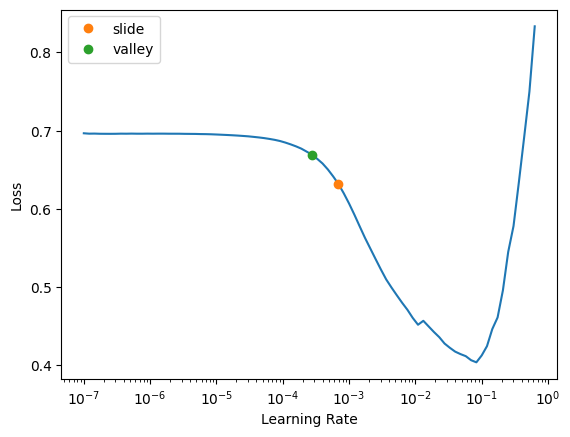

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(2,4.75e-4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.071024,0.067416,0.976682,01:32
1,0.065893,0.063992,0.976548,01:31


In [ ]:
learner.save("book-classifier-stage-0")

Path('models/book-classifier-stage-0.pth')

In [ ]:
learner.export("models/book-classifier-stage-0.pkl")

In [ ]:
# learner.load("book-classifier-stage-0")

# Stage - 1

In [ ]:
learner.unfreeze()

SuggestedLRs(slide=0.00019054606673307717, valley=0.00013182566908653826)

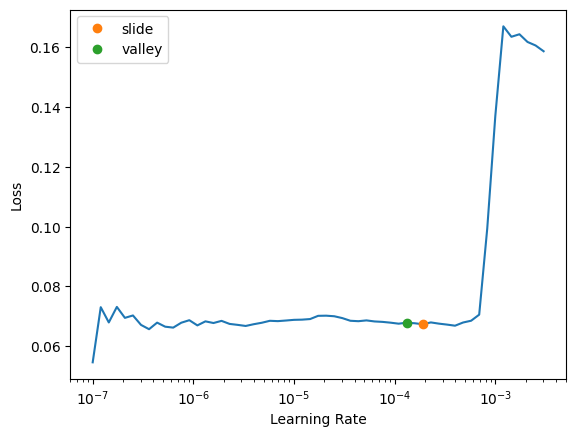

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(3,slice(0.00013182566908653826, 0.00019054606673307717))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.067873,0.064205,0.977634,02:19
1,0.058867,0.056936,0.978636,02:14
2,0.051786,0.054069,0.978298,02:15


In [ ]:
learner.save("book-classifier-stage-1")

Path('models/book-classifier-stage-1.pth')

In [ ]:
learner.export("models/book-classifier-stage-1.pkl")